# The LSTM Model

In [1]:
import pandas as pd
import numpy as np
import random
from statsmodels.tsa.stattools import pacf
from matplotlib.pyplot import figure
from statsmodels.tsa.arima.model import ARIMA
# !pip install scikit-learn==0.24
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_lattice as tfl
import matplotlib.ticker as ticker
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
df = pd.read_csv("WorldCases.csv", index_col = False)
df.reset_index(drop=True, inplace=True)
# countries we are interested in
countries = ["Japan", "Canada", "Brazil", "Argentina", "Singapore", "Italy", "The United Kingdom"]
df1 = df[countries]
df1.insert(0, "date", df["date"])
df = df1
df# import data
df = pd.read_csv("WorldCases.csv", index_col = False)
df.reset_index(drop=True, inplace=True)
df.head()

,date,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,United States Virgin Islands,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Wallis and Futuna,Yemen,Zambia,Zimbabwe
0,2020-02-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
1,2020-02-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2020-02-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2020-02-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-02-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0


# Data Smoothing
- Remove day of week effect by replace $y_t$ with an average of 7 previous days(inclusive)
    - Each value is an average of data from all 7 different weekdays, thud day of week effect removed

In [4]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# for each country
df1 = df.copy()  # deep copy
df1 = df1.iloc[6:]
for country in countries:
    # holder
    temp = []
    # take average, starting from 7th day
    for i in range(6,len(df)):
        # remove day of week effect
        ave = np.mean(df[country].iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
        temp.append(ave)
    df1[country] = temp
df1.set_index("date", inplace=True)

In [5]:
# input: original dataset, country we want
# output: all data, sorted by date, of that country
def extract(dataset, country):
    # select data only from the input country
    temp = dataset.to_dict()[country]
    temp = pd.Series(temp)
    # reset index
    # temp.reset_index(drop=True, inplace=True)
    return temp

# Data Preprocessing
## Differencing
- Differencing of time series in discrete time
- transformation of series to a new time series wehre values are the difference between consecutive values of previous series
- help stablizing the mean of time series by removing trend

In [6]:
# create a differenced series, output as Series
# interval: order of differencing, default = 1
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        # no need to difference
        if (interval == 0):
            value = dataset[i]
        else:
            value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
# invert differenced value
# input: single original, single prediction, interval(default as 1)
def invert_difference(history, yhat, interval=1):
    if (interval == 0):
        return yhat
    else:
        return yhat + history

## Scaling
- Scale the data to [-1,1]

In [7]:
# scale train and test data to [-1, 1]
# input: train(np array, train_size*1), test(np array, test_size*1)
def scale(train, test):
    # find scalers
    aveTrain = np.mean(train)
    maxTrain = max(train)
    minTrain = min(train)
    scaler = [aveTrain, maxTrain, minTrain]
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = (train - aveTrain)/(maxTrain-minTrain)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = (test - aveTrain)/(maxTrain-minTrain)
    return scaler, train_scaled, test_scaled
# inverse scaling for a forecasted value
# input: scaler, single prediction yhat
def invert_scale(scaler, yhat):
    inverted = yhat*(scaler[1]-scaler[2]) + scaler[0]
    return inverted[0][0]  # output: a number

## Reshaping

In [8]:
# convert to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg  # output: a data frame
# prepare data for neural networks
def prepare_nn(series, diff, train_size, test_size, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # differencing
    diff_series = difference(raw_values, diff)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # split into train & test
    train_diff, test_diff = diff_values[:(train_size-diff)], diff_values[(train_size-diff):]
    # rescaling
    scaler, train_scaled, test_scaled = scale(train_diff, test_diff)
    # adjust data type for train_scaled, test_scaled
    train_scaled = [row[0][0] for row in train_scaled]
    test_scaled = [row[0][0] for row in test_scaled]
    # convert to supervised
    train = series_to_supervised(train_scaled, n_lag, n_seq).values
    test = series_to_supervised(test_scaled, n_lag, n_seq).values
    return scaler, train, test  # scaler: list of np array, train: np array, test: np array

# Model Training

In [9]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = keras.Sequential()
    model.add(layers.LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(layers.Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# Make Forecasts

In [10]:
# make one forecast with an LSTM
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]][0]
# evaluate the model
def make_lstm(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff):
    forecasts = []
    prev = raw_value[-(test_size+diff):(len(raw_value)-diff)]  # Y_(t-diff)
    for i in range(len(test)):
        X = test[i, 0:n_lag]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # invert scaling
        forecast = invert_scale(scaler, forecast)
        # invert differencing
        forecast = invert_difference(prev[i], forecast)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

## Evaluation with RMSE, MAE, MAPE

In [11]:
# evaluate RMSE for each step in forcasting
def evaluate_forecasts(truth, forecasts):
    rmse = np.sqrt(mean_squared_error(truth, forecasts))
    mae = mean_absolute_error(truth, forecasts)
    truth = np.array(truth)
    forecasts = np.array(forecasts)
    mape = mean_absolute_percentage_error(truth, forecasts)*100
    return rmse, mae, mape

## A Single Trial as Demo

In [12]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
diff = 1 # order of difference
train_size = 63  # train set size
test_size = 18 # test set size

n_batch = 1
nb_epoch = 100
n_neurons = 1
country = "Singapore"

In [13]:
# prepare data
s = extract(df1, country)
raw_value = s[-(train_size+test_size+n_lag):]
scaler, train, test = prepare_nn(raw_value, diff, train_size, test_size, n_lag, n_seq)

In [14]:
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
# make forecasts
forecasts = make_lstm(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
evaluate_forecasts(raw_value[-test_size:], forecasts)

(229.9495788198459, 171.29771289773396, 6.593125315230395)

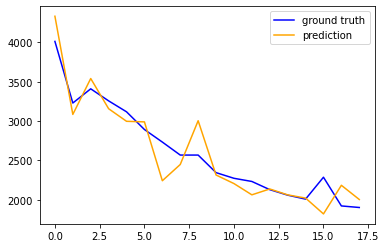

In [15]:
truth = raw_value[-test_size:].to_list()
plt.plot(truth, color = 'blue', label = "ground truth")
plt.plot(forecasts, color = 'orange', label = "prediction")
plt.legend()
plt.savefig("LSTM_demo.png", dpi=600)

# Perform on All Countries, All Trials

In [16]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
diff = 1 # order of difference
train_size = 63  # train set size
test_size = 18 # test set size

n_step = 7  # step size

n_batch = 1
nb_epoch = 100
n_neurons = 1

In [17]:
# holder for rmse:
RMSE = []
MAE = []
MAPE = []

for i in range(len(countries)):
    country = countries[i]
    s = extract(df1, country)
    temp_RMSE = []
    temp_MAE = []
    temp_MAPE = []
    for j in range(0, len(df1)-(train_size+test_size+n_lag)+1, n_step):
        # prepare data
        raw_value = s[j:j+(train_size+test_size+n_lag)]
        
        # for lstm
        scaler, train, test = prepare_nn(raw_value, diff, train_size, test_size, n_lag, n_seq)
        model = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
        forecasts = make_lstm(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
        rmse_LSTM, mae_LSTM, mape_LSTM = evaluate_forecasts(raw_value[-test_size:], forecasts)
        
        temp_RMSE.append(rmse_LSTM)
        temp_MAE.append(mae_LSTM)
        temp_MAPE.append(mape_LSTM)
    
    RMSE.append(temp_RMSE)
    MAE.append(temp_MAE)
    MAPE.append(temp_MAPE)
    print(country)

Japan
Canada
Brazil
Argentina
Singapore
Italy
The United Kingdom


In [18]:
for i in range(len(countries)):
    country = countries[i]
    temp_RMSE = RMSE[i]
    temp_MAE = MAE[i]
    temp_MAPE = MAPE[i]
    
    curr = {"rmse": temp_RMSE, "mae": temp_MAE, "mape": temp_MAPE}
    curr = pd.DataFrame(curr)
    curr.to_csv(country+"_single_lstm.csv", index = False)

In [19]:
curr

,rmse,mae,mape
0,112.515175,86.075591,1.873335
1,99.622743,82.034712,2.028364
2,124.256990,106.854716,2.988400
3,126.455403,111.103907,3.696889
4,72.557361,57.398150,2.365066
...,...,...,...
118,540.498261,488.898610,4.026278
119,295.958397,255.189228,3.059490
120,212.831672,172.874390,2.417594
121,128.505509,110.468826,2.230294


In [20]:
ave_rmse = []
ave_mae = []
ave_mape = []
for i in range(len(countries)):
    country = countries[i]
    temp_RMSE = RMSE[i]
    temp_MAE = MAE[i]
    temp_MAPE = MAPE[i]
    
    ave_rmse.append(np.mean(temp_RMSE))
    ave_mae.append(np.mean(temp_MAE))
    ave_mape.append(np.mean(temp_MAPE))

LSTM = {"country": countries, "rmse": ave_rmse, "mae": ave_mae, "mape": ave_mape}
LSTM = pd.DataFrame(LSTM)
LSTM

,country,rmse,mae,mape
0,Japan,1038.108764,825.591755,7.318284
1,Canada,257.971075,209.032879,4.142429
2,Brazil,2240.164050,1684.599079,4.830595
3,Argentina,641.230271,496.171211,5.273476
4,Singapore,129.473829,100.908843,8.020566
5,Italy,1123.086204,934.564975,3.942236
6,The United Kingdom,1001.228272,812.399201,2.808385


In [21]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

# alternative:
# scipy.stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

In [22]:
# import data
meanCI_rmse = []
meanCI_mae = []
meanCI_mape = []
for country in countries:
    df = pd.read_csv(country + '_single_lstm.csv', index_col = False)
    df.reset_index(drop=True, inplace=True)
    rmse = df[["rmse"]]
    mean_rmse, h_rmse = mean_confidence_interval(rmse, confidence=0.95)
    meanCI_rmse.append([mean_rmse, h_rmse])
    
    mae = df[["mae"]]
    mean_mae, h_mae = mean_confidence_interval(mae, confidence=0.95)
    meanCI_mae.append([mean_mae, h_mae])
    
    mape = df[["mape"]]
    mean_mape, h_mape = mean_confidence_interval(mape, confidence=0.95)
    meanCI_mape.append([mean_mape, h_mape])

In [23]:
meanCI_rmse

[[1038.108763950768, array([383.11217178])],
 [257.9710751117521, array([94.43818046])],
 [2240.164049805617, array([355.5211982])],
 [641.2302705111124, array([193.37769768])],
 [129.47382907391602, array([35.56837552])],
 [1123.0862044951803, array([356.4794442])],
 [1001.2282724031276, array([352.23053505])]]

In [24]:
meanCI_mae

[[825.5917545769323, array([302.57544397])],
 [209.03287940176796, array([80.71228773])],
 [1684.5990788999452, array([263.05947177])],
 [496.1712105010552, array([163.7557148])],
 [100.90884286537758, array([28.2475493])],
 [934.5649747135659, array([313.47015151])],
 [812.3992008312188, array([281.8435754])]]

In [25]:
meanCI_mape

[[7.318283682541367, array([1.7182998])],
 [4.142429182265778, array([0.66852232])],
 [4.830595211796965, array([0.54995509])],
 [5.273475504400236, array([0.92760309])],
 [8.02056642430838, array([1.32722546])],
 [3.942235692119057, array([0.56881659])],
 [2.808385389381984, array([0.2717917])]]